In [1]:
folder_path = f"/home/jhongfongfah/PYTORCH_PROJ/[Hong] week04"

# Image Classification by DNN

The goal of image classification is to classify an image $x$ into one of $K$ classes. DNN implements this as a non-linear function that maps $x$ to a $K$-dim vector $y$ representing the probability of being each class. Once $y$ is obtained, the class (i.e., row) of the largest value in $y$ is considered as the predicted class of $x$. To train such DNNs, we provide a training dataset, a collection of an image $x$ and its ground truth class label $t$ pairs.

* Input: an image $x$ ($64{\times}64$ grayscale in this exercise).
* Output: a $K$-dim vector $y$ representing the probability of being each class.
* Supervision: the ground truth class $t \in \mathbb{Z} (0 \le t < K)$ of $x$.

We use PyTorch to implement DNN in this exercise.  PyTorch follows "define by run" programming model, and its scripts mainly consist of the following three parts:

1. Data (`torch.utils.data.Dataset` and `torch.utils.data.DataLoader`),
2. Network (`torch.nn.Sequential`, `torch.nn.Module`), and
3. Training (`torch.optim.SGD`).


### References
* [Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)
* "Deep Learning" by I. Goodfellow et al. ([online version](https://www.deeplearningbook.org/))

# 0. Data

The following cell loads an NPZ file that includes images and labels.
* `IMG`: numpy array of 64x64 grayscale images. Each image contains one handwritten Japanese character.  (source [ETL Character Database](http://etlcdb.db.aist.go.jp))
* `MOJI`: numpy array of Python string corresponding to the character of the images.
* `LABEL`: numpy array of integers representing the class ID $[0:955]$. The first $[0:74]$ IDs are hiragana.
* `HIRA`: numpy arrary of integers. $1$ if the image is hiragana and $0$ otherwise.


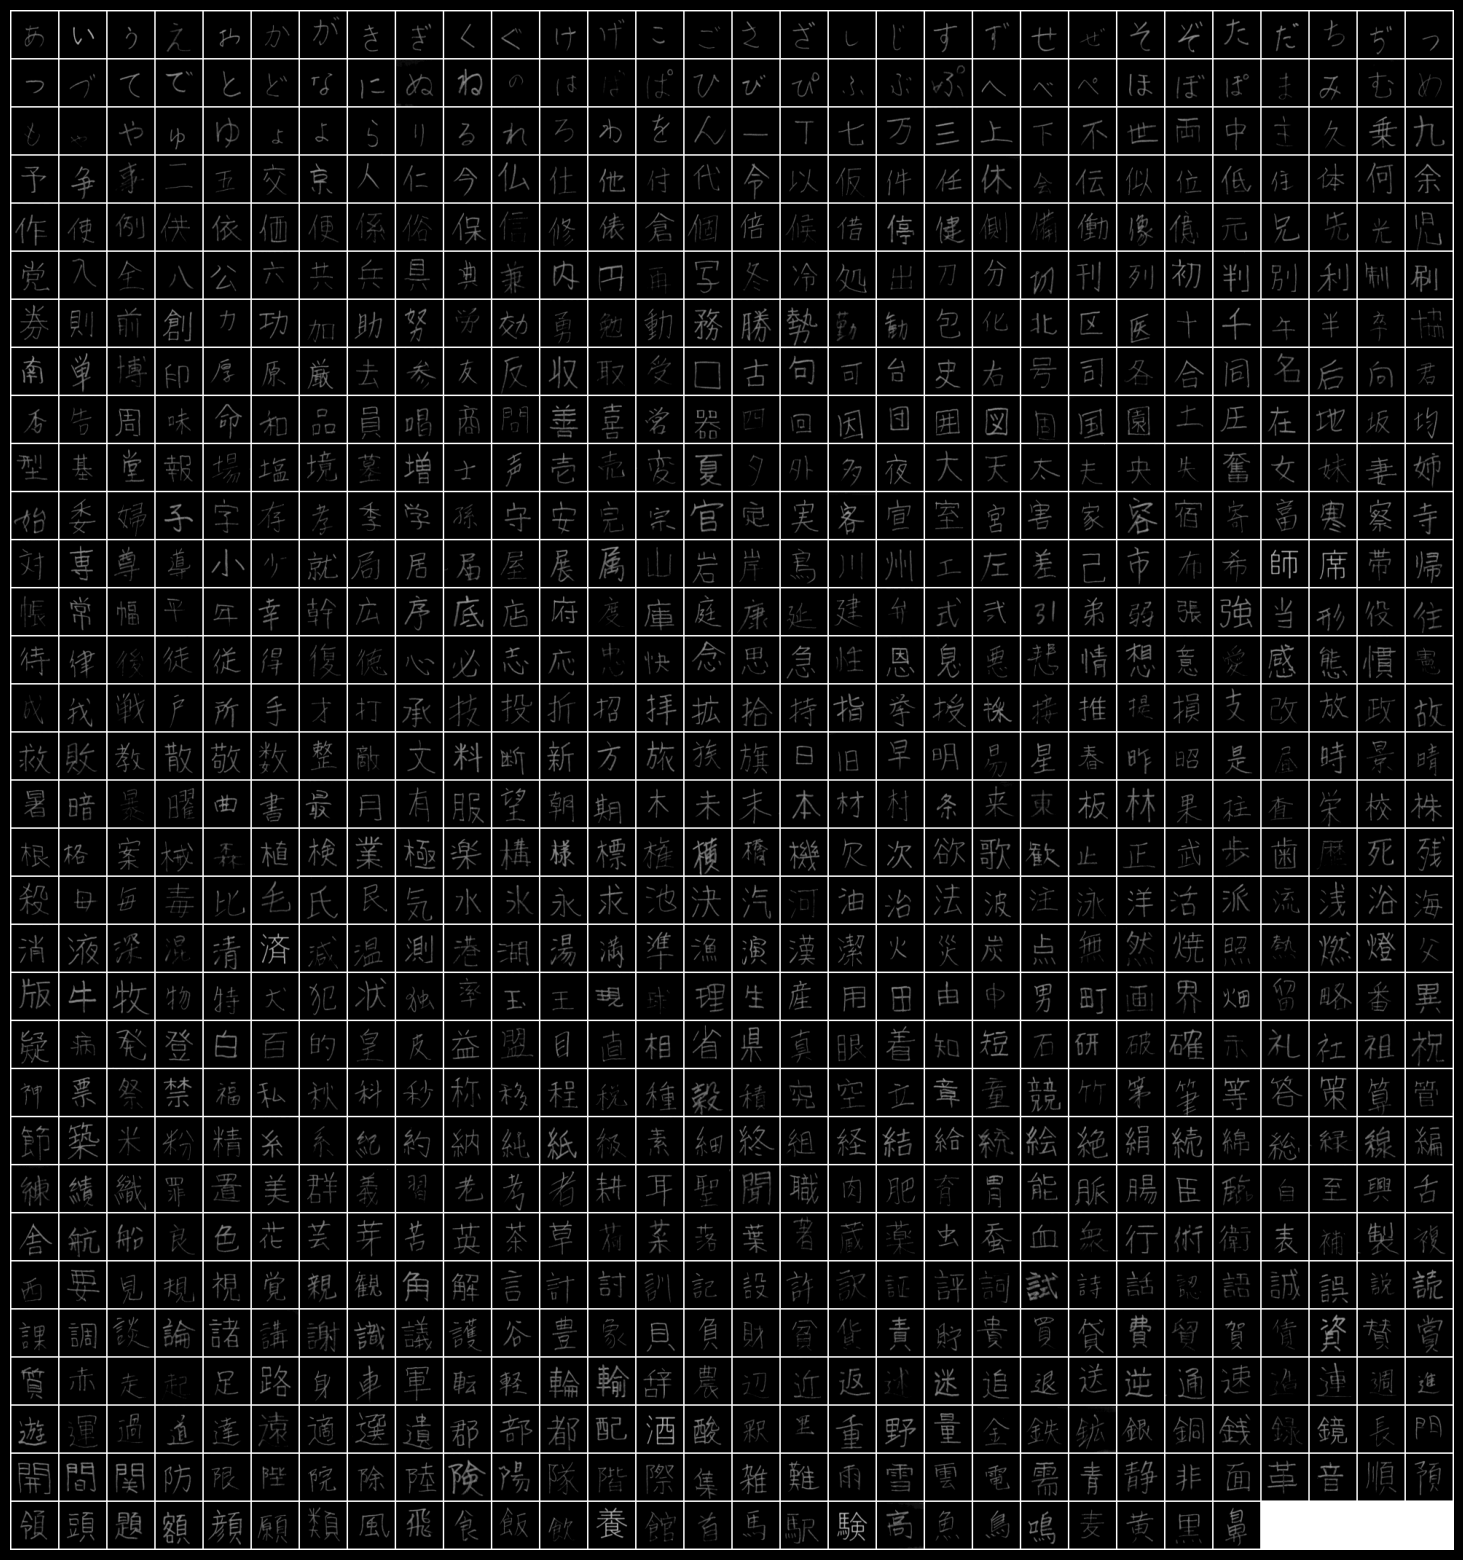

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import PIL
from PIL import Image

SKIP=10
assert 160 % SKIP == 0

DATA = np.load(f'{folder_path}/Practice_DNN/ETL8G_64x64.npz')

# 64x64 images, 956 characters, 160 images per class
IMG = DATA['img']

# the label [0:955] of each image.  [0:74] == hiragana, [75:] == kanji
LABEL = DATA['label'].astype(np.int64)

# the character of each image
MOJI = DATA['moji']

# if the character is a hiragana or not
HIRA = DATA['hira'].astype(np.int64)

if SKIP > 1:
    IMG = IMG[::SKIP,:,:]
    LABEL = LABEL[::SKIP]
    MOJI = MOJI[::SKIP]
    HIRA = HIRA[::SKIP]

# show thumbnails
plt.figure(figsize=(20.0, 20.0))
grid = torchvision.utils.make_grid(torch.from_numpy(IMG[::160//SKIP,None,:,:].astype(float) / 255), nrow=30, pad_value=1)
plt.imshow(grid.clamp(0, 1).permute(1, 2, 0).expand(-1, -1, 3).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Exercise

Train a network that estimates the label (available as `LABEL`) of $x$.  This can be done by implementing
1. a new dataset,
2. a new dataloader, and
2. a new network.


You can first try a "hiragana-only" case for simplicity.  That is, you can define a subset of $x$ which includes hiragana only, and then predict its hiragana label.


## Hiragana-Only

### HiraOnly - **DataSet**

In [3]:
# Create Hiragana-Only Arrays
IMG_HiraOnly = IMG[HIRA == 1]
MOJI_HiraOnly = MOJI[HIRA == 1]
LABEL_HiraOnly = LABEL[HIRA == 1]

### HiraOnly - **DataLoader**

In [4]:
# Split
from sklearn.model_selection import train_test_split
I_HiraOnly_train, I_HiraOnly_test, L_HiraOnly_train, L_HiraOnly_test = train_test_split(IMG_HiraOnly, LABEL_HiraOnly)
print('IMG  : ', I_HiraOnly_train.shape, I_HiraOnly_test.shape)
print('LABEL: ', L_HiraOnly_train.shape, L_HiraOnly_test.shape)

class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support of transforms.
    https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index, :, :]
        if self.transform:
            x = self.transform(PIL.Image.fromarray(x))

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5],std=[0.5])
])

# data loader
def get_dataloader(dataset, batch_size=128, shuffle=True, device=None):
    uses_cuda = False if device is None else device.type == 'cuda'
    return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            #num_workers=4 if uses_cuda else 0,
            pin_memory=uses_cuda  # True if CUDA
            )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 50
train_loader = get_dataloader(CustomTensorDataset((I_HiraOnly_train, L_HiraOnly_train), transform), batch_size = batch_size, device=device)
test_loader = get_dataloader(CustomTensorDataset((I_HiraOnly_test, L_HiraOnly_test), transform), batch_size = batch_size, device=device)


IMG  :  (900, 64, 64) (300, 64, 64)
LABEL:  (900,) (300,)
cuda


In [5]:
print(f'len(train_loader) = {len(train_loader)}')
print(f'len(test_loader) = {len(test_loader)}')

len(train_loader) = 18
len(test_loader) = 6


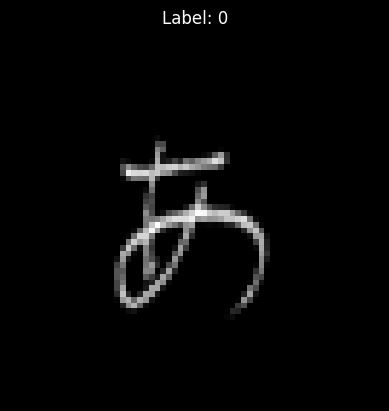

In [6]:
# Plot the image
num = 0
plt.imshow(IMG_HiraOnly[num], cmap='gray')
plt.title(f'Label: {LABEL_HiraOnly[num]}')
plt.axis('off')  # Hide axis
plt.rcParams['font.family'] = 'Noto Serif CJK JP'
plt.show()

### HiraOnly - **Network**

In [7]:
import torch
import torch.nn as nn

class LabelModel_HiraOnly(nn.Module):
    def __init__(self):
        super(LabelModel_HiraOnly, self).__init__()
        # We can reuse stateless modules safely. https://discuss.pytorch.org/t/reusing-nn-dropout-relu-maxpool-in-forward/75409/4
        self.act = nn.LeakyReLU(0.2)  # LeakyReLU activation with negative slope of 0.2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # MaxPooling with 2x2 kernel
        self.drop = nn.Dropout(p=0.5)  # Dropout with probability 0.5
        self.num_class = 75 # 75 different Hiraganas

        # Define the first block of the network using nn.Sequential
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), self.act,  # Convolution, BatchNorm, Activation
            nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64), self.act,  # Convolution, BatchNorm, Activation
            self.pool,  # MaxPooling
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,  # Convolution, BatchNorm, Activation
            nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,  # Convolution, BatchNorm, Activation
            self.pool,  # MaxPooling
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,  # Convolution, BatchNorm, Activation
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,  # Convolution, BatchNorm, Activation
            self.pool,  # MaxPooling
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), self.act,  # Convolution, BatchNorm, Activation
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), self.act,  # Convolution, BatchNorm, Activation
            self.pool,  # MaxPooling
            # nn.Conv2d(512, 1024, 3, 1, 1), nn.BatchNorm2d(1024), self.act,  # Convolution, BatchNorm, Activation
            # nn.Conv2d(1024, 1024, 3, 1, 1), nn.BatchNorm2d(1024), self.act,  # Convolution, BatchNorm, Activation
            # self.pool,  # MaxPooling
        )

        # Define the second block of the network using nn.Sequential
        self.block2 = nn.Sequential(
            nn.Linear(4*4*512, 4096), self.act, self.drop,  # Fully connected, Activation, Dropout
            nn.Linear(4096, 4096), self.act, self.drop,  # Fully connected, Activation, Dropout
            nn.Linear(4096, self.num_class),  # Output layer
        )

    def forward(self, x):
        # Pass input through the first block (convolutional layers)
        x = self.block1(x)
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Pass the flattened output through the second block (fully connected layers)
        x = self.block2(x)
        return x

# Instantiate the model and move it to the specified device (GPU or CPU)
model = LabelModel_HiraOnly().to(device)

# Print the model architecture and the device being used
print(model)
print(device)

LabelModel_HiraOnly(
  (act): LeakyReLU(negative_slope=0.2)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm

### HiraOnly - **Training**

In [8]:
OUTNAME = f'{folder_path}/My_Code/DNN_01_HiraOnly_output'
N_epoch = 100

lr = 0.001
wd = 1e-4

optimizer = torch.optim.Adagrad(model.parameters(), lr = lr, weight_decay = wd)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []
for epoch in range(1, 1+N_epoch):
    print(f"Epoch [{epoch + 1}/{epoch}]")
    # Switch to training mode
    model.train()
    # Per-minibatch training
    loss_sum = 0
    input_count = 0
    bar = tqdm(train_loader, desc='Train Epoch: %d' % epoch, unit='batches')
    for inputs, labels in bar:
        input_count += len(inputs)
        # transfer to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        # loss computation
        loss = criterion(outputs, labels)
        # initialize the gradient
        optimizer.zero_grad()
        # update the gradient
        loss.backward()
        # update the parameters
        optimizer.step()
        # show losses
        loss_sum += loss.item() * len(inputs)
        bar.set_postfix(loss_avg=loss_sum / input_count)
    train_losses.append(loss_sum/input_count)
    # Switch to inference mode
    model.eval()
    loss_sum = 0
    correct_sum = 0
    input_count = 0
    with torch.no_grad(): # We do not need autograd for inference
        bar = tqdm(test_loader, desc='Test', unit='batches')
        for inputs, labels in bar:
            input_count += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_sum += criterion(outputs, labels).item() * len(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct_sum += pred.eq(labels.view_as(pred)).sum().item()
            bar.set_postfix(loss_avg=loss_sum / input_count, accuracy=correct_sum / input_count)
    test_loss, test_accuracy = loss_sum / input_count, 100 * correct_sum / input_count

    # save the model if it is better than before
    if len(test_losses) > 1 and test_loss < min(test_losses):
        torch.save(model.state_dict(), f'{OUTNAME}_best_loss.tar')

    if len(test_accuracies) > 1 and test_accuracy > max(test_accuracies):
        torch.save(model.state_dict(), f'{OUTNAME}_best_accuracy.tar')

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

torch.save(model.state_dict(), f'{OUTNAME}.tar')


Train Epoch: 1:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 2:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 3:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 4:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 5:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 6:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 7:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 8:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 9:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 10:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 11:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 12:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 13:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 14:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 15:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 16:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 17:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 18:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 19:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 20:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 21:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 22:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 23:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 24:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 25:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 26:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 27:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 28:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 29:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 30:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 31:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 32:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 33:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 34:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 35:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 36:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 37:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 38:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 39:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 40:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 41:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 42:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 43:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 44:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 45:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 46:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 47:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 48:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 49:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 50:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 51:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 52:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 53:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 54:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 55:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 56:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 57:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 58:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 59:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 60:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 61:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 62:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 63:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 64:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 65:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 66:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 67:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 68:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 69:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 70:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 71:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 72:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 73:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 74:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 75:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 76:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 77:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 78:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 79:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 80:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 81:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 82:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 83:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 84:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 85:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 86:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 87:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 88:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 89:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 90:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 91:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 92:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 93:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 94:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 95:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 96:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 97:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 98:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 99:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]

Train Epoch: 100:   0%|          | 0/18 [00:00<?, ?batches/s]

Test:   0%|          | 0/6 [00:00<?, ?batches/s]